# For Windows
1. Please download the latest SASview v5 package from
   https://github.com/SasView/sasview/tags
2. Install SASview
3. Adjust the *sasviewProgramPath* variable accordingly for the path where SasView was installed.

## In case of error
<pre style="background: #fdd">
    CalledProcessError: Command '['gcc', ...
</pre>
Please start the previously installed SASview at least once and create a plot with the desired model function. This will build the selected model from C-sources into a python library in the directory <br />
`C:\Users\{user}\.sasmodels\compiled_models\sas32_{model}.so`

If it still fails, it might be caused by OpenCL being installed while the *pyopencl* package can not be imported in jupyter notebook/lab. Try to disable OpenCL entirely by setting `os.environ["SAS_OPENCL"] = "none"` early in the code and check that the desired SASview model was build already (see above).

# McSAS example

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from os.path import expanduser
# disable OpenCL if it causes problems
os.environ["SAS_OPENCL"] = "none"
# set the location where the sasview-sasmodels are installed:
homedir = expanduser("~")
sasviewProgramPath = os.path.join(homedir, "AppData", "Local", "SasView")
if sasviewProgramPath not in sys.path:
    sys.path.append(sasviewProgramPath)
from mcsas3 import mcmodel, mcopt, mccore

%matplotlib inline
import matplotlib.pyplot as plt
from pandas import read_csv

TEST1 4117.419818042391
Optimization started
chiSqr: 4117.419818042391, N accepted: 0 / 0
chiSqr: 4117.419818042391, N accepted: 0 / 1
chiSqr: 111.93265751731637, N accepted: 362 / 1001
chiSqr: 12.67129466896139, N accepted: 515 / 2001
chiSqr: 2.4171869169046887, N accepted: 592 / 3001
chiSqr: 1.195984704706266, N accepted: 623 / 4001
Final chiSqr: 0.9937703183015671, N accepted: 631
TEST1 4266.899625930302
Optimization started
chiSqr: 4266.899625930302, N accepted: 0 / 0
chiSqr: 4212.439997111624, N accepted: 1 / 1
chiSqr: 117.01833120291688, N accepted: 371 / 1001
chiSqr: 13.390758469913413, N accepted: 528 / 2001
chiSqr: 2.162083479573045, N accepted: 615 / 3001
Final chiSqr: 0.9585541864267484, N accepted: 646
TEST1 4509.657384053122
Optimization started
chiSqr: 4509.657384053122, N accepted: 0 / 0
chiSqr: 4497.923014377679, N accepted: 1 / 1
chiSqr: 148.00896163291634, N accepted: 358 / 1001
chiSqr: 10.394551149146947, N accepted: 539 / 2001
chiSqr: 1.7551019569776065, N accepted:

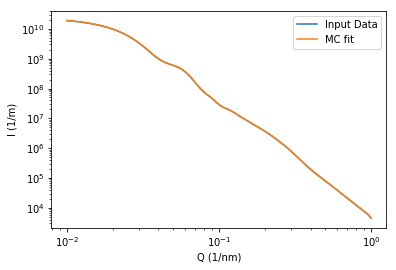

In [3]:
# import data
qs = read_csv("quickstartdemo1.csv", delimiter = ';',
              header = None, names = ["Q", "I", "ISigma"])
# Q needs to be in a list as in [Q] or [Qx,Qy]
# measured intensity I (same shape as Q) and uncertainties ISigma
measData = dict(Q = [qs.Q.values], I = qs.I.values,
                ISigma = qs.ISigma.values)

# create a model
mod = mcmodel.McModel(modelName = "sphere", nContrib = 300, modelDType="default",
                      fitParameterLimits = {"radius": (3, 315)}, 
                      staticParameters = {"background": 0,
                                          "sld" : 1e+6,
                                          "sld_solvent" : 0, })
# initialize optimization settings
opt = mcopt.McOpt(maxIter = 1e5, convCrit = 1)

for rep in range(3):
    opt.repetition = rep
    mod.resetParameterSet()
    mc = mccore.McCore(measData, model = mod, opt = opt)
    print("TEST1", opt.gof)
    mc.optimize()
    mod.kernel.release()
    print("Final chiSqr: {}, N accepted: {}"
          .format(opt.gof, opt.accepted))
    # storing the results
    mc.store(filename = "results.h5")

from mcsas3.mcmodelhistogrammer import McModelHistogrammer
from mcsas3.mcanalysis import McAnalysis
import pandas as pd
histRanges = pd.DataFrame(dict(
    parameter=("radius", "radius"),
    nBin=(25, 25),
    binScale=("linear", "linear"),
    presetRangeMin=(None, 1),
    presetRangeMax=(None, 150),
    binWeighting=("vol", "vol"),
    
    autoRange=(True, False)))
mcana = McAnalysis("results.h5", measData, histRanges, store=True)

# plotting the intensity match
plt.plot(measData["Q"][0], measData["I"], label = "Input Data")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Q (1/nm)")
plt.ylabel("I (1/m)")
scale, background = mc._opt.x0[0], mc._opt.x0[1]
plt.plot(measData["Q"][0], mc._opt.modelI*scale + background,
         label = "MC fit")
_ = plt.legend(loc = 0)

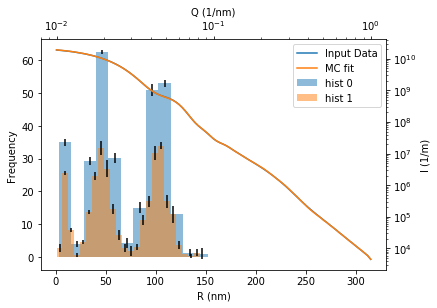

In [30]:
# plotting the intensity match
import numpy as np
rect=[0.1,0.1,0.8,0.8]
a1=plt.axes(rect)
a1.yaxis.tick_left()
for i in range(len(histRanges)):
    mcana.debugPlot(i, alpha=0.5, label="hist {}".format(i))
plt.xlabel("R (nm)")
plt.ylabel("Frequency")

a2=plt.axes(rect, frameon=False)
a2.xaxis.set_label_position('top')
a2.yaxis.set_label_position('right')
a2.xaxis.tick_top()
a2.yaxis.tick_right()
plt.plot(measData["Q"][0], measData["I"],
         label = "Input Data", zorder=1)
scale, background = mc._opt.x0[0], mc._opt.x0[1]
plt.plot(measData["Q"][0], mc._opt.modelI*scale + background,
         label = "MC fit", zorder=2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Q (1/nm)")
plt.ylabel("I (1/m)")

combined = [x for a in (a2, a1)
              for x in zip(*a.get_legend_handles_labels())]
_ = a2.legend(*list(zip(*combined)))